# P3 Concevez une application au service de la santé publique 

L'agence <span style='color:blue'> <a href = "http://www.santepubliquefrance.fr/">"*Santé publique France*" </a></span> a lancé un appel à projets pour trouver des idées innovantes d’applications en lien avec l'alimentation. <br>
Vous souhaitez y participer et proposer une idée d’application.

Le jeu de données <font color='orange'>Open Food Facts</font> est disponible sur le <a href = "https://world.openfoodfacts.org/">site officiel</a> (ou disponible à <a href ="https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip">ce lien</a> en téléchargement).
<br>
Les variables sont définies à <a href = "https://world.openfoodfacts.org/data/data-fields.txt">cette adresse</a>

Les champs sont séparés en quatre sections :

- Les informations générales sur la fiche du produit : nom, date de modification, etc.
- Un ensemble de tags : catégorie du produit, localisation, origine, etc.
- Les ingrédients composant les produits et leurs additifs éventuels.
- Des informations nutritionnelles : quantité en grammes d’un nutriment pour 100 grammes du produit.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import os

import missingno as msno

Erreur: pandas lors de l'import, certaines colonnes possèdent des valeurs de types differents:

Correction parametrer  l'argument low_memory à False

In [ ]:
%%time
if os.path.exists("fr.openfoodfacts.org.products.csv"):
    openfoodfacts = pd.read_csv("fr.openfoodfacts.org.products.csv",sep='\t',low_memory=False)

prendre 1 echant en parametre / 
figer typ de chaq col

Le code cidessous permet de créer un rapport automatisé de notre dataframe.

%%time
from pandas_profiling import ProfileReport
profile = ProfileReport(openfoodfacts.sample(int(round(openfoodfacts.shape[0]*0.01,ndigits=0))), title="Pandas Profiling Report")
profile.to_file("output.html")

In [ ]:
openfoodfacts.info()

Le fichier comtient 106 variables numeriques et 56 varriables catégoriques

In [ ]:
nbLigne, nbCol = openfoodfacts.shape
nbLigne, nbCol

### Etude du nombre de valeurs manquantes

In [ ]:
nbNaVariable = pd.DataFrame(openfoodfacts.isnull().sum().sort_values(),columns = ["Nombre NA"])

In [ ]:
nbNaVariable.head(10)

On voit que 23 produits ne possède pas de code bar. Que sont ces produits?

In [ ]:
openfoodfacts[openfoodfacts.code.isnull()]

Ce sont des produits laitiers. Peut etre qu'il faut les supprimer.

In [ ]:
openfoodfacts = openfoodfacts.loc[~openfoodfacts.code.isna()]

In [ ]:
nbLigne, nbCol = openfoodfacts.shape
nbNaVariable = pd.DataFrame(openfoodfacts.isnull().sum().sort_values(),columns = ["Nombre NA"])
nbLigne, nbCol

### Etudes des Doublons

In [ ]:
openfoodfacts.duplicated().sum()

In [ ]:
openfoodfacts.code.nunique()/openfoodfacts.shape[0]

On ne trouve pas de valeurs manquantes.
Il y a-t'il des erreurs?

In [ ]:
openfoodfacts.code.str.replace('[a-zA-Z]','A',regex=True).str.replace('[0-9]','N',regex=True).value_counts()

In [ ]:
openfoodfacts.code.str.replace('[a-zA-Z]','A',regex=True).str.zfill(41).str.replace('[0-9]','N',regex=True).value_counts()

In [ ]:
openfoodfacts[openfoodfacts.code.str.zfill(41)=='00000000000000000000000000000000000016117'][['url']].iloc[1].values

</br>

</br>

# Etude des types de variables

In [ ]:
pd.options.display.max_rows,pd.options.display.max_columns

In [ ]:
pd.set_option("display.max_rows", 60) #parametre le nombre de ligne affichable dans dataframe pandas
pd.set_option("expand_frame_repr", True) #permet de deplier les colonnes cachées
pd.set_option("display.max_columns",200 ) #permet d'afficher jusqu'à 200 colonnes dans une cellule

In [ ]:
openfoodfacts.sample(2)

In [ ]:
nomColonnes = pd.DataFrame({'Colonnes':openfoodfacts.columns})
nomColonnes.T

In [ ]:
# Categoriser les types de colonnes
#info general
general_information = nomColonnes.Colonnes[:10].values.tolist()

#tags
tags = nomColonnes.Colonnes[10:21].values.tolist() + nomColonnes.Colonnes[24:34].values.tolist()

#les ingredients
ingredients = nomColonnes.Colonnes[34:40].values.tolist()

#
misc_data = nomColonnes.Colonnes[40:52].values.tolist() + nomColonnes.Colonnes[54:63].values.tolist()

#Les vvaleurs nutritionnelles
nutrition_facts = nomColonnes.Colonnes[63:157].values.tolist() + nomColonnes.Colonnes[160:162].values.tolist()


#Les scores nutritionnelles
score_foot_print = nomColonnes.Colonnes[52:54].values.tolist() + nomColonnes.Colonnes[157:160].values.tolist()

labels = nomColonnes.Colonnes[21:24].values.tolist()

#Remplir colonnes type_de_données
nomColonnes['type_de_colonne'] = ''

nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(general_information)] = "general_information"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(tags)] = "tags"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(ingredients)] = "ingredients"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(misc_data)] = "misc_data"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(nutrition_facts)] = "nutrition_facts"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(score_foot_print)] = "score_foot_print"
nomColonnes.type_de_colonne[nomColonnes.Colonnes.isin(labels)] = "labels"

In [ ]:
nomColonnes.T

In [ ]:
nomColonnes = nomColonnes.merge(right=nbNaVariable.reset_index(),left_on='Colonnes',right_on='index',how='left').drop(columns=['index'])

</br>

</br>

</br>

</br>

## Supprimer les colonnes en double

In [ ]:
col_to_drop = []
colgarder = []

### les valeurs manquantes

In [ ]:
# les variables general_information
msno.matrix(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(general_information)]]);

In [ ]:
openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(general_information)]].isna().sum()/nbLigne

#### Creation de la variable url_page_name 
> Idée: Completer la variable categorie ou product name

In [ ]:
openfoodfacts.url.unique()

In [ ]:
openfoodfacts.url.str.replace('^http://world-fr.openfoodfacts.org/produit/[0-9]+/','',regex=True).unique()

#### Completer na colonne product name
> si le product name est na prendre url_name

</br>

</br>

</br>

In [ ]:
# general_information
col_to_drop += ['generic_name','url','creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime']
colgarder += ['code','product_name','quantity']

#Maj general_information
[general_information.remove(x) for x in col_to_drop]
general_information

</br>

</br>

</br>

In [ ]:
# les variables tags
msno.matrix(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(tags)]]);

In [ ]:
openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(tags)]].isna().sum()/nbLigne

In [ ]:
# les données de catégories
openfoodfacts[['code','categories_fr','categories','categories_tags','main_category','main_category_fr']].isna().sum()/nbLigne


In [ ]:
msno.bar(openfoodfacts[['code','categories_fr','categories','categories_tags','main_category','main_category_fr']]);

In [ ]:
msno.heatmap( openfoodfacts[['categories_fr','categories','categories_tags','main_category','main_category_fr']] );

main_categorie et categories_fr sont rempli de la meme façon.

In [ ]:
# tags
col_to_drop += [ 'packaging','packaging_tags','brands','brands_tags',
                'origins','origins_tags','manufacturing_places','manufacturing_places_tags',
                'cities','cities_tags','countries','countries_tags','countries_fr',
                'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo',
                'categories', 'categories_tags',
                'purchase_places', 'stores']

colgarder += ['categories_fr']

#Maj tags
[tags.remove(x) for x in [ 'packaging','packaging_tags','brands','brands_tags','emb_codes', 'emb_codes_tags', 
                           'origins','origins_tags','manufacturing_places','manufacturing_places_tags',
                          'cities','cities_tags','countries','countries_tags','countries_fr',
                          'first_packaging_code_geo','purchase_places', 'stores','categories', 
                          'categories_tags']]
tags

In [ ]:
# Il n'est pas possible de créer une super variable catégories
# Idée trouver modele category ~ f(X)

</br>

</br>

</br>

In [ ]:
#les variables ingredients
msno.matrix(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(ingredients)]]);

In [ ]:
# ingredients
col_to_drop += ['ingredients_text','allergens', 'allergens_fr', 'traces', 'traces_tags','traces_fr']
#colgarder += ['ingredients_text']

#Maj tags
[ingredients.remove(x) for x in [ 'ingredients_text','allergens', 'allergens_fr', 'traces', 'traces_tags', 'traces_fr']]
ingredients

In [ ]:
openfoodfacts.loc[openfoodfacts.code=='3017620422003']

</br>

</br>

</br>

In [ ]:
#les variables misc_data
msno.matrix(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(misc_data)]]);

In [ ]:
misc_data

In [ ]:
# creation colonne "ingredients_from_palm_oil_nb"

In [ ]:
# misc_data
col_to_drop += ['no_nutriments',
                'additives','additives_tags','additives_fr',
                'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags',
                'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags',
                'pnns_groups_1', 'pnns_groups_2',
                'states', 'states_tags', 'states_fr',
                'main_category',
                'image_url', 'image_small_url']


colgarder += ['serving_size','additives_n', 'main_category_fr',
              'ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n',]

#Maj tags
[misc_data.remove(x) for x in [ 'no_nutriments',
                               'additives','additives_tags','additives_fr', 
                               'ingredients_from_palm_oil', 'ingredients_from_palm_oil_tags',
                               'ingredients_that_may_be_from_palm_oil', 'ingredients_that_may_be_from_palm_oil_tags', 
                               'pnns_groups_1', 'pnns_groups_2',
                               'states', 'states_tags', 'states_fr',
                               'main_category',
                               'image_url', 'image_small_url']]
misc_data

</br>

</br>

</br>

In [ ]:
# les variables score_foot_print
msno.matrix(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(score_foot_print)]]);

In [ ]:
openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(score_foot_print)]].isna().sum()/nbLigne

In [ ]:
#openfoodfacts[[ 'nutrition-score-fr_100g', 'openfoodfacts.nutrition_grade_fr']].boxplot()
sns.boxplot(y='nutrition-score-fr_100g',
            x='nutrition_grade_fr',
            data=openfoodfacts.sample(10000).sort_values(by='nutrition_grade_fr'));

In [ ]:
# score_foot_print
col_to_drop += ['nutrition_grade_uk','carbon-footprint_100g', 'nutrition-score-uk_100g']

colgarder += ['nutrition_grade_fr', 'nutrition-score-fr_100g']

#Maj tags
[score_foot_print.remove(x) for x in ['nutrition_grade_uk','carbon-footprint_100g', 'nutrition-score-uk_100g']]
score_foot_print

</br>

</br>

</br>

In [ ]:
# les variables score_foot_print
msno.matrix(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(labels)]]);

In [ ]:
openfoodfacts[openfoodfacts.labels.notna()][openfoodfacts.columns[openfoodfacts.columns.isin(labels)]].sample(5)

In [ ]:
openfoodfacts[openfoodfacts.labels.notna()][openfoodfacts.columns[openfoodfacts.columns.isin(labels)]].describe()

In [ ]:
openfoodfacts['presenceDeLabels'] = openfoodfacts.labels.notna()*1


# MAJ du DF nomColonnes
nomColonnes = pd.concat([nomColonnes,pd.DataFrame({'Colonnes':'presenceDeLabels',
                                                   'type_de_colonne':'score_foot_print',
                                                   'Nombre NA':openfoodfacts.presenceDeLabels.isna().sum()},
                                                 index = [openfoodfacts.presenceDeLabels.isna().sum()])], 
                        axis=0)

In [ ]:
# labels

# Variables à supprimer
col_to_drop += ['labels','labels_tags','labels_fr']

# Variables à conserver
colgarder += ['presenceDeLabels']

#Maj tags
[labels.remove(x) for x in ['labels','labels_tags','labels_fr']]
labels

</br>

</br>

</br>

In [ ]:
# nutrition_facts
msno.bar(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(nutrition_facts)][:47] ]);

In [ ]:
msno.bar(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(nutrition_facts)][47:] ]);

In [ ]:
pd.DataFrame(openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(nutrition_facts)] ].isna().sum()/nbLigne).T\
.style.background_gradient(cmap='Blues').format("{:.2%}")

In [ ]:
thresold = 0.6
print('Au total le jeu de données contient {} colonnes contenant des informations sur les valeurs nutritives. \nParmi ces colonnes, {} sont composées de plus de {pourc:.0%} de valeurs manquantes'
      .format((nomColonnes.type_de_colonne=='nutrition_facts').sum(),
              (openfoodfacts.loc[:,openfoodfacts.columns[openfoodfacts.columns.isin(nutrition_facts)] ].isna().sum()>=nbLigne*thresold).sum(),pourc=thresold
              ))

nbin = 10
interbin = 100/nbin

xlab = ['<{:.0f}%'.format(interbin) if i==0 else '({:.0f}%-{:.0f}%]'.format(i*interbin,(i+1)*interbin) for i in range(nbin)]
ycut = pd.cut(nomColonnes[nomColonnes.type_de_colonne=='nutrition_facts']['Nombre NA']/nbLigne, 
                     [ i/nbin for i in range(nbin+1)], # ajoute 1 pour obtenir la derniere tranche
                     include_lowest=False).value_counts().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 6))

axes[0].set_title('Repartition des valeurs manquantes')
sns.barplot(x=ycut.index, y=ycut,ax=axes[0] )
axes[0].set_xticks(range(nbin))   # Attention cette fois on ajoute pas +1
axes[0].set_xticklabels(xlab, rotation=90)
axes[0].bar_label(axes[0].containers[0])

axes[1].set_title('Repartition des valeurs manquantes cumulée')
sns.barplot(x=ycut.index, y=ycut.cumsum(),ax=axes[1] )
axes[1].set_xticks(range(nbin))# Attention cette fois on ajoute pas +1
axes[1].set_xticklabels(xlab, rotation=90)
axes[1].bar_label(axes[1].containers[0])

;

In [ ]:
ytotcut = pd.cut(nomColonnes[nomColonnes.type_de_colonne!='nutrition_facts']['Nombre NA']/nbLigne, 
                     [ i/nbin for i in range(nbin+1)], # ajoute 1 pour obtenir la derniere tranche
                     include_lowest=False).value_counts().sort_index()

fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12, 6))

fig.suptitle('Les autres valeurs')
axes.set_title('Repartition des valeurs manquantes')
sns.barplot(x=ytotcut.index, y=ytotcut,ax=axes )
axes.set_xticks(range(nbin))   # Attention cette fois on ajoute pas +1
axes.set_xticklabels(xlab, rotation=90)
axes.bar_label(axes.containers[0])

;

In [ ]:
# nutrition_facts

print('le seuil ',thresold)
for col,typc,nNa in zip(nomColonnes.Colonnes,
                        nomColonnes.type_de_colonne,
                        nomColonnes['Nombre NA']) :
    if typc =='nutrition_facts':
        if nNa >= (nbLigne * thresold): # suppr col qui possèdent 95% de valeurs nulles
            col_to_drop.append(col)
        else:
            colgarder.append(col)

In [ ]:
colgarder

In [ ]:
print('Parmi les {} colonnes, nous en supprimons {} et gardons {}'.format(nbCol,len(col_to_drop),len(colgarder) ) )

</br>

In [ ]:
colgarder

In [ ]:
# A-t-on oublié certaines colonnes
[x  for x in openfoodfacts.columns if x not in col_to_drop+colgarder ]

In [ ]:
openfoodfacts.serving_size.dtypes

In [ ]:
etude_test = openfoodfacts[openfoodfacts.columns[(~openfoodfacts.columns.isin(nutrition_facts)) & (openfoodfacts.columns.isin(colgarder))]]\
.drop(columns=['code','ingredients_text','product_name','categories_fr','main_category_fr'])

In [ ]:
etude_test.columns

In [ ]:
sns.pairplot(etude_test, hue="nutrition_grade_fr")

In [ ]:
openfoodfacts[colgarder].corr().style.background_gradient(cmap='Blues').format("{:.2%}")

In [ ]:
etude_test.serving_size[etude_test.serving_size.notna()].str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).value_counts().index[:5].to_list()+etude_test.quantity[etude_test.quantity.notna()].str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).value_counts().index[:10].to_list()

In [ ]:
openfoodfacts[['quantity','url','serving_size']][etude_test.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True)=='xg'].sample(10)

In [ ]:
unites = {
    #les liquides
    'l' : 'litre', 'ml': 'litre', 'cl': 'litre', 'litre': 'litre','litres': 'litre',
    'floz': 'litre', 'xcl':'litre','xml': 'litre', 'g/ml':'litre', 'le':'litre',
    
    # les aliments solides (ou mous)
    'kg': 'poids','g' : 'poids', 'gr': 'poids', 'oz': 'poids', 'xg': 'poids',  'ge': 'poids',
    'grammes': 'poids','г': 'poids',  'xg=g': 'poids', 'ozg': 'poids', 'grs': 'poids', 'lb': 'poids',
    
    # ceux qui peuvent etre definis
    'kg[x]': 'petit pot/yaourt', 'gml': 'bocal/conserve', 'mlg':'creme/sauce',
    
    # part ou portion de ensemble plus grand
    'sachets': 'unité','oeufs': 'unité','tranches': 'unité','x': 'unité',
    
}

unitesAbb = [
    #les liquides
    'l' , 'ml', 'cl', 'litre','litres', 'floz', 'xcl','xml', 'g/ml', 'le',
    
    # les aliments solides (ou mous)
    'kg','g' , 'gr', 'oz', 'xg',  'ge', 'grammes','г',  'xg=g', 'ozg', 'grs', 'lb',
    
    # ceux qui peuvent etre definis
    'kg[x]', 'gml', 'mlg',
    
    # part ou portion de ensemble plus grand
    'sachets','oeufs','tranches','x'
]

In [ ]:
#creation colonnes unites mini
openfoodfacts['unites_abb'] = [y if y in unitesAbb else x if x in unitesAbb else np.nan for x,y in zip(openfoodfacts.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True),
                    openfoodfacts.serving_size.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True) )]

#creation colonnes unites
openfoodfacts['unites'] = [y if not y is np.nan else x for x,y in zip(openfoodfacts.quantity.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).map(unites),
                    openfoodfacts.serving_size.str.lower().str.replace('\\(.+[^(]\\)','',regex=True)\
.str.replace('[0-9]','',regex=True)\
.str.replace('[\\,\\*\\. ]','',regex=True)\
.str.replace(' ','',regex=True).map(unites))]

In [ ]:
etude_test[openfoodfacts['unites_abb'].isna()].sample(10)

In [ ]:
openfoodfacts['unites_abb'].value_counts().plot(kind='bar')

In [ ]:
openfoodfacts['unites'].value_counts().plot(kind='bar')

In [ ]:
# get dummies
openfoodfacts[['bocal/conserve','creme/sauce','litre','petit pot/yaourt','poids','unité']] = pd.get_dummies(openfoodfacts.unites)

In [ ]:
colgarder += ['bocal/conserve','creme/sauce','litre','petit pot/yaourt','poids','unité']

## Gestions des valeurs manquantes

In [ ]:
pd.set_option('max_colwidth',-1)

In [ ]:
#fillna

# nutrition_facts
openfoodfacts[nutrition_facts] = openfoodfacts[nutrition_facts].fillna(0,inplace=False)

## Gestion des outliers

#### les boxplots

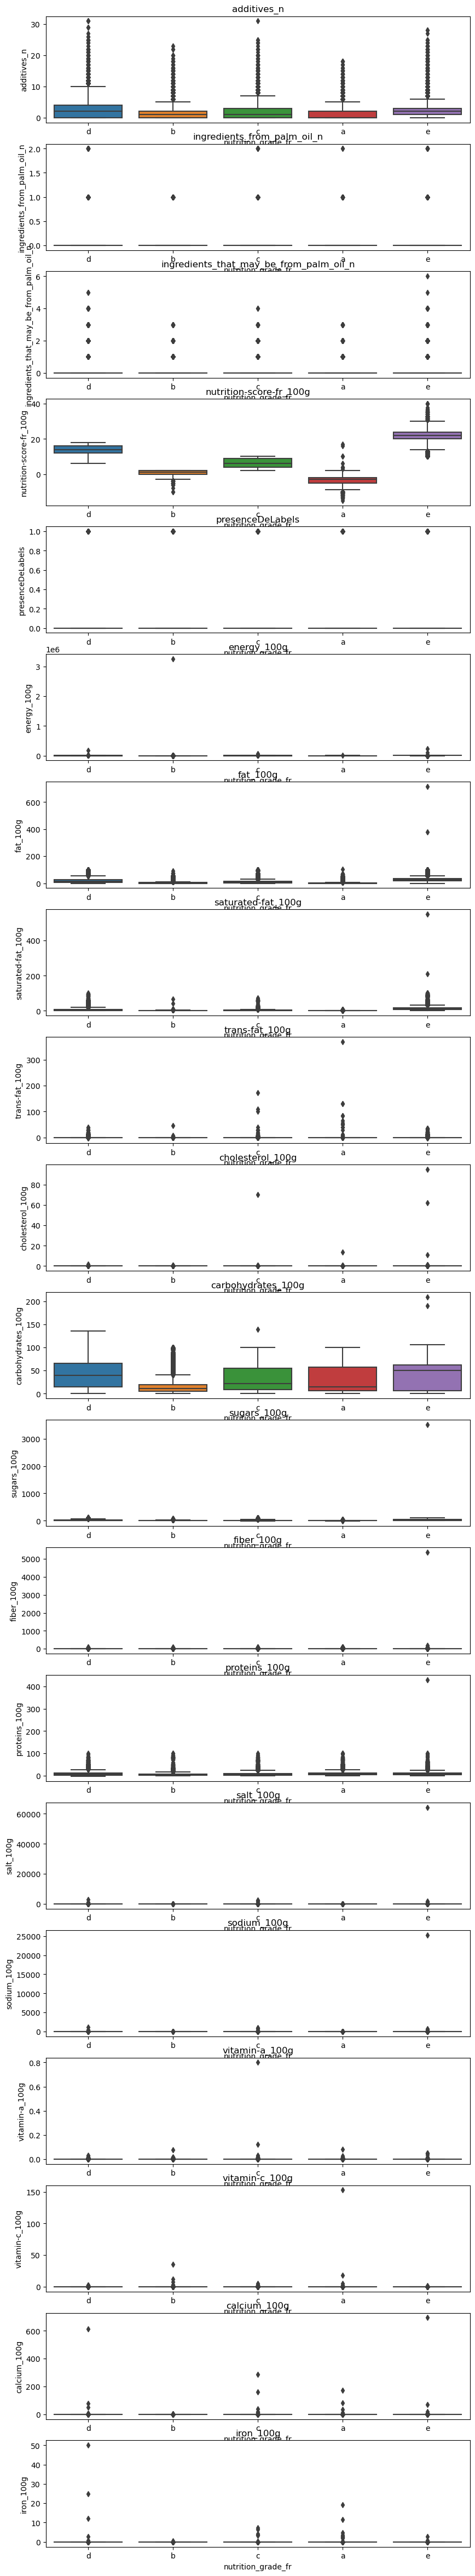

In [139]:
imp = 0
fig,axes = plt.subplots(nrows = 20,ncols = 1,figsize=(10,60))
for i,col in enumerate( colgarder ):
    if openfoodfacts[col].dtypes in ['float64','int32']:
        sns.boxplot(x= 'nutrition_grade_fr', y= col,data = openfoodfacts,ax=axes[i-imp])
        axes.flatten()[i-imp].set_title(col)
    else:
        imp += 1
    

In [ ]:
Bcp de outliers

In [ ]:
openfoodfacts[open]

In [ ]:
# Z score
from scipy import stats
import numpy as np
 
z = np.abs(stats.zscore(openfoodfacts[nutrition_facts[1]]))
print(z)

threshold = 3
 
# Position of the outlier
#print(np.where(z > 3))

openfoodfacts[nutrition_facts[1]][525]

#print(len(np.where(z > 3)))

In [ ]:

for i in nutrition_facts[:10]:
    openfoodfacts[[i]+['nutrition_grade_fr']].boxplot(by='nutrition_grade_fr', 
                                                                       column=i, 
                                                                       grid=False)

In [ ]:
#Ci dessous la liste des colonnes que l'on garde

In [ ]:
pd.options.display.max_rows=80
pd.DataFrame(openfoodfacts[openfoodfacts.columns[~openfoodfacts.columns.isin(nomColonnes.Colonnes[nomColonnes.type_de_colonne=='nutrition_facts'])]].notna().sum()/nbLigne)\
.style.background_gradient(cmap='Blues').format("{:.2%}")

## Creation dataframe etude

In [ ]:
df_openfoodfacts = openfoodfacts[colgarder]

if not os.path.exists('df_openfoodfacts.csv'):
    df_openfoodfacts.to_csv('df_openfoodfacts.csv',sep='\t',encoding='utf-8',index=False)

In [ ]:
pd.set_option('max_colwidth', -1)

In [ ]:
openfoodfacts.loc[openfoodfacts.quantity.isna() & openfoodfacts.serving_size.notna()][['product_name','url','quantity','categories_fr','serving_size','additives_n','main_category_fr']]\
.sample(5)

In [ ]:
pd.DataFrame({'quantservcomp':[quant if not quant is np.nan else serv for quant,serv in zip(openfoodfacts.quantity,openfoodfacts.serving_size) ]}).isna().sum()/nbLigne

In [ ]:
openfoodfacts.ingredients_text.sample(5).str.split(',', expand=True)

In [ ]:
openfoodfacts[["main_category_fr",'categories_fr']].describe()

In [ ]:
#supprimer element entre parenthèse
(?<!m)

In [ ]:
openfoodfacts.ingredients_text[297693]

In [ ]:
openfoodfacts.ingredients_text.str.lower().replace('\\(   .+   (  ?<!\\(  )  \\)','',regex=True)[297693]

In [ ]:
openfoodfacts.ingredients_text.str\
.lower().str\
.replace('\\([^(]+\\)','',regex=True).str\
.split(',', expand=True).iloc[:,0].str\
.replace('organic','').str\
.replace('^ ','').describe()


In [ ]:
pd.options.display.max_rows=60

In [ ]:
openfoodfacts.columns[~openfoodfacts.columns.isin(nutrition_facts)].to_list()

In [ ]:
msno.matrix(df_openfoodfacts[df_openfoodfacts.columns[~df_openfoodfacts.columns.isin(nutrition_facts)].to_list()])

In [ ]:
msno.heatmap(df_openfoodfacts[['quantity','serving_size']])

</br>

</br>

</br>

### Supprimer les colonnes qui possèdent beaucoups de valeurs non nulles

In [ ]:
# Le % de valeurs manquantes et les colonnes à conserver
nomColonnes["%Na"] = nomColonnes['Nombre NA']/nbLigne
nomColonnes["NoNa"] = (nbLigne - nomColonnes['Nombre NA'])
nomColonnes["colASupp"] = nomColonnes.Colonnes.isin(col_to_drop)

In [ ]:
nomColonnes.colASupp[nomColonnes['Nombre NA'] > (nbLigne * 0.95)] = True

In [ ]:
for x in nomColonnes.Colonnes[(nomColonnes.type_de_colonne=='nutrition_facts') & (nomColonnes.colASupp == True)]:
    nutrition_facts.remove(x)

In [ ]:
for nut in nutrition_facts:
    if nut in nomColonnes.Colonnes[(nomColonnes.type_de_colonne=='nutrition_facts') & (nomColonnes.colASupp == False)]:
        colgarder += [nut]

In [ ]:
nomColonnes[nomColonnes.colASupp==False].groupby(['type_de_colonne'])['%Na'].describe().T

In [ ]:
fig,axes = plt.subplots(nrows = 7,ncols = 1,figsize=(20,40))
for i,typcol in enumerate( nomColonnes.type_de_colonne.unique() ):
    sns.barplot(data = nomColonnes[nomColonnes.type_de_colonne==typcol], x = 'Colonnes' , y = '%Na',ax=axes[i])
    axes[i].title.set_text(typcol)
    axes[i]
    if len(nomColonnes.Colonnes[nomColonnes.type_de_colonne==typcol])>10:
        axes[i].tick_params(axis='x', rotation=60, labelsize=7)


In [ ]:
fig,axes = plt.subplots(nrows = 7,ncols = 1,figsize=(20,40))
for i,typcol in enumerate( nomColonnes.type_de_colonne.unique() ):
    sns.barplot(data = nomColonnes[nomColonnes.type_de_colonne==typcol], x = 'Colonnes' , y = '%Na',ax=axes[i])
    axes[i].title.set_text(typcol)
    axes[i]
    if len(nomColonnes.Colonnes[nomColonnes.type_de_colonne==typcol])>10:
        axes[i].tick_params(axis='x', rotation=60, labelsize=7)


In [ ]:
plt.figure(figsize=(12,4))
sns.barplot(x=pd.cut(x=nomColonnes['%Na'], bins=20).value_counts().index ,y = pd.cut(x=nomColonnes['%Na'], bins=20).value_counts())
plt.title('Répartition du nombre de valeurs manquantes')
plt.xticks(rotation = 90);

In [ ]:
[
 nomColonnes.colASupp[:50].sum(),
 nomColonnes.colASupp[50:100].sum(),
 nomColonnes.colASupp[100:130].sum(),
 nomColonnes.colASupp[130:162].sum()
]#32 24 5

In [ ]:
general_information + ingredients + misc_data + score_foot_print + tags + labels + nutrition_facts

In [ ]:
openfoodfacts[['ingredients_text']].iloc[198025].str.replace('\(.*\)','',regex=True)

In [ ]:
"eerr"